# Music Genre Classification

## Imports

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import json
import scipy
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

In [ ]:
"""
Import dataset from kaggle:
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
"""

In [34]:
path_data = 'Data/genres_original/'
genre = 'blues/'
filename = 'blues.00000.wav'

file_path = path_data + genre + filename
fs = 22050

## Data Augmentation

In [36]:
def get_mfccs(directory_path, fs=22500, duration=30, n_fft=2048, hop_length=512, n_mfcc=13, num_segments=10):
    data = {
        "genre_name": [],
        "genre_num": [],
        "mfcc": []
    }
    samples_per_track = fs * duration
    samps_per_segment = int(samples_per_track/num_segments)
    mfccs_per_segment = math.ceil(samps_per_segment/hop_length)

    print("MFCC collection started!")
    print("========================")
    for i, (path_current, folder_names, file_names) in enumerate(os.walk(directory_path)):
        if path_current is not directory_path:
            path_list = path_current.split('/')
            genre_current = path_list[-1]

            for file in file_names:
                file_path = os.path.join(path_current, file).replace(os.sep, '/')
                try:
                    audio, fs = librosa.load(file_path, sr=fs)

                    for seg in range(num_segments):
                        start_sample = seg * samps_per_segment
                        end_sample = start_sample + samps_per_segment
                        mfcc = librosa.feature.mfcc(y=audio[start_sample:end_sample],
                                                    sr=fs,
                                                    n_fft=n_fft,
                                                    hop_length=hop_length,
                                                    n_mfcc=n_mfcc)

                        mfcc = mfcc.T
                        if len(mfcc) == mfccs_per_segment:
                            data["genre_name"].append(genre_current)
                            data["genre_num"].append(i-1)
                            data["mfcc"].append(mfcc.tolist())
                except:
                    continue
            print(f"Collected MFCCs for {genre_current.title()}!")

    with open('Data/data.json', "w") as filepath:
        print("========================")
        print("Saving data to disk...")
        json.dump(data, filepath, indent=4)
        print("Saving complete!")
        print("========================")

    return np.array(data["mfcc"]), np.array(data["genre_name"]), np.array(data["genre_num"])

In [37]:
%%time
n_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 10
track_duration = 30

directory_path = 'Data/genres_original/'
mfccs, genres, genre_nums = get_mfccs(directory_path,
                          fs=fs,
                          duration=track_duration,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          n_mfcc=n_mfcc,
                          num_segments=num_segments)

MFCC collection started!
Collected MFCCs for Metal!
Collected MFCCs for Disco!
Collected MFCCs for Pop!
Collected MFCCs for Classical!
Collected MFCCs for Reggae!
Collected MFCCs for Country!
Collected MFCCs for Rock!
Collected MFCCs for Hiphop!


<ipython-input-36-6d05392ef2cb>:21: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(file_path, sr=fs)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Collected MFCCs for Jazz!
Collected MFCCs for Blues!
Saving data to disk...
Saving complete!
CPU times: user 2min 12s, sys: 1min 13s, total: 3min 25s
Wall time: 2min 20s


In [10]:
print(f"MFCCs: {mfccs.shape}")
print(f"genres: {genres.shape}")

MFCCs: (9986, 130, 13)
genres: (9986,)


In [11]:
genre_map = dict(zip(sorted(set(genres)), np.arange(0, 10)))
genres_num = np.array(pd.Series(genres).map(genre_map))

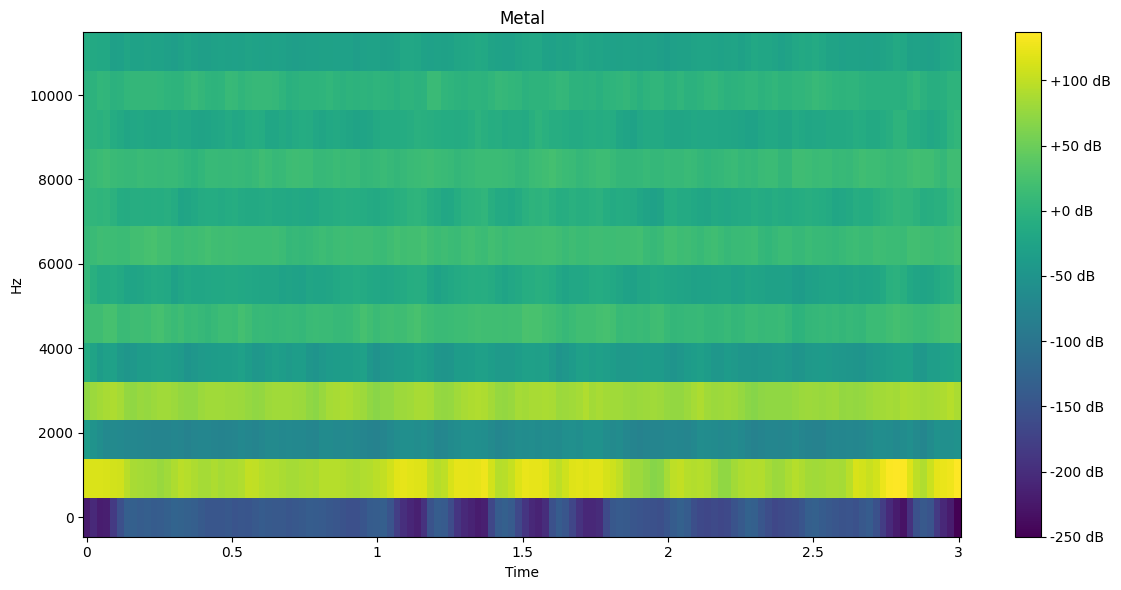

In [12]:
idx = 0
plt.figure(figsize=(12,6))
librosa.display.specshow(data=mfccs[idx].T, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
plt.title('MFCCs')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.title(f"{genres[idx].title()}");

## Training

In [13]:
filepath = 'Data/data.json'
with open(filepath, "r") as fp:
    data = json.load(fp)

In [14]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4893, 130, 13), y training data shape: (4893,)
X validation data shape: (2097, 130, 13), y validation data shape: (2097,)


In [16]:
class DeepNN(nn.Module):
    def __init__(self, input_shape, num_classes=10):
        super(DeepNN, self).__init__()
        self.flatten_dim = input_shape[0] * input_shape[1]
        self.fc1 = nn.Linear(self.flatten_dim, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 64)
        self.dropout3 = nn.Dropout(0.3)
        self.output = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1, self.flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.softmax(self.output(x), dim=1)
        return x

In [38]:
def plot_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch [1/250], Train Loss: 2.2465, Train Acc: 0.1907, Val Loss: 2.1629, Val Acc: 0.2866
Epoch [2/250], Train Loss: 2.1536, Train Acc: 0.2965, Val Loss: 2.1014, Val Acc: 0.3500
Epoch [3/250], Train Loss: 2.1268, Train Acc: 0.3247, Val Loss: 2.0786, Val Acc: 0.3729
Epoch [4/250], Train Loss: 2.1021, Train Acc: 0.3493, Val Loss: 2.0632, Val Acc: 0.3901
Epoch [5/250], Train Loss: 2.0854, Train Acc: 0.3642, Val Loss: 2.0501, Val Acc: 0.4010
Epoch [6/250], Train Loss: 2.0684, Train Acc: 0.3854, Val Loss: 2.0498, Val Acc: 0.3982
Epoch [7/250], Train Loss: 2.0527, Train Acc: 0.4022, Val Loss: 2.0312, Val Acc: 0.4258
Epoch [8/250], Train Loss: 2.0421, Train Acc: 0.4145, Val Loss: 2.0191, Val Acc: 0.4316
Epoch [9/250], Train Loss: 2.0411, Train Acc: 0.4130, Val Loss: 2.0144, Val Acc: 0.4406
Epoch [10/250], Train Loss: 2.0261, Train Acc: 0.4298, Val Loss: 2.0178, Val Acc: 0.4382
Epoch [11/250], Train Loss: 2.0218, Train Acc: 0.4320, Val Loss: 2.0005, Val Acc: 0.4506
Epoch [12/250], Train Loss: 2.

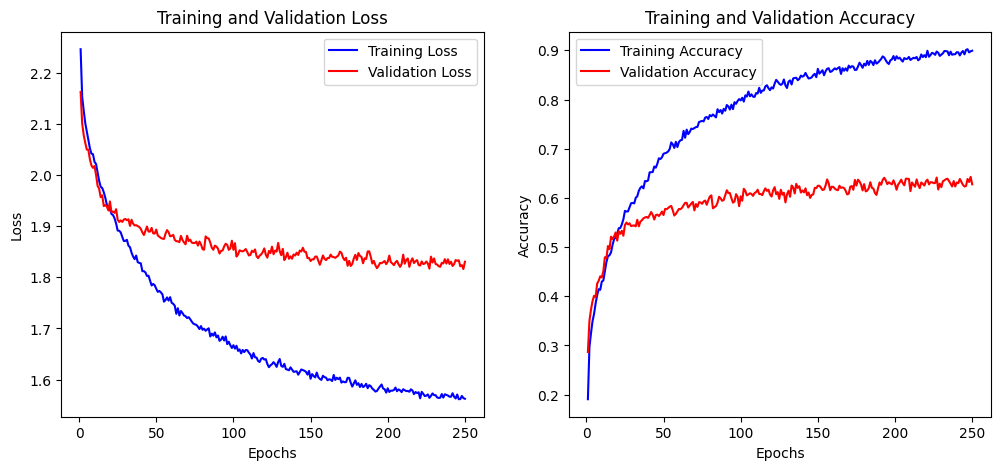

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model_dnn = DeepNN(input_shape=X_train.shape[1:3]).to(device)

optimizer = optim.Adam(model_dnn.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 250
start_time = time.time()
for epoch in range(num_epochs):
    model_dnn.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_dnn(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_accuracy = correct / total
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model_dnn.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_dnn(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [40]:
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape

(4893, 130, 13, 1)

In [41]:
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.flatten_dim = self._calculate_flatten_dim(input_shape)
        self.fc1 = nn.Linear(self.flatten_dim, 64)
        self.output = nn.Linear(64, num_classes)

    def _calculate_flatten_dim(self, input_shape):
        x = torch.zeros(1, *input_shape)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        return x.numel()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, self.flatten_dim)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.output(x), dim=1)
        return x

In [42]:
print("X_train_cnn shape:", X_train_cnn.shape)
print("X_val_cnn shape:", X_val_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)

X_train_cnn shape: (4893, 130, 13, 1)
X_val_cnn shape: (2097, 130, 13, 1)
X_test_cnn shape: (2996, 130, 13, 1)


Epoch [1/250], Train Loss: 2.1744, Train Acc: 0.2857, Val Loss: 2.0972, Val Acc: 0.3734
Epoch [2/250], Train Loss: 2.0721, Train Acc: 0.3948, Val Loss: 2.0578, Val Acc: 0.4058
Epoch [3/250], Train Loss: 2.0428, Train Acc: 0.4255, Val Loss: 2.0479, Val Acc: 0.4144
Epoch [4/250], Train Loss: 2.0275, Train Acc: 0.4394, Val Loss: 2.0445, Val Acc: 0.4154
Epoch [5/250], Train Loss: 2.0221, Train Acc: 0.4419, Val Loss: 2.0279, Val Acc: 0.4392
Epoch [6/250], Train Loss: 1.9996, Train Acc: 0.4668, Val Loss: 2.0287, Val Acc: 0.4340
Epoch [7/250], Train Loss: 1.9957, Train Acc: 0.4723, Val Loss: 2.0094, Val Acc: 0.4588
Epoch [8/250], Train Loss: 1.9879, Train Acc: 0.4788, Val Loss: 2.0065, Val Acc: 0.4607
Epoch [9/250], Train Loss: 1.9755, Train Acc: 0.4882, Val Loss: 2.0013, Val Acc: 0.4673
Epoch [10/250], Train Loss: 1.9744, Train Acc: 0.4889, Val Loss: 1.9904, Val Acc: 0.4807
Epoch [11/250], Train Loss: 1.9685, Train Acc: 0.4972, Val Loss: 1.9892, Val Acc: 0.4769
Epoch [12/250], Train Loss: 1.

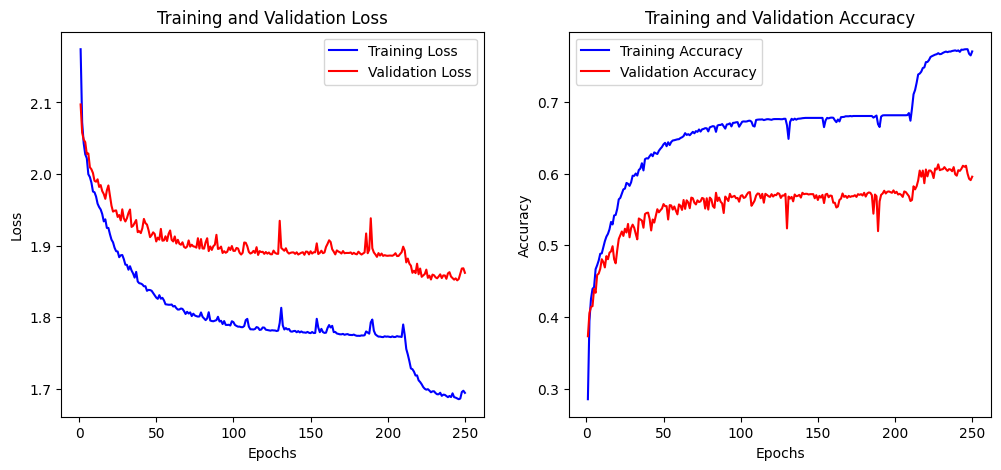

In [43]:
input_shape = (1, 130, 13)
model_cnn1 = CNNModel(input_shape).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_cnn_tensor = torch.tensor(X_train_cnn, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_cnn_tensor = torch.tensor(X_val_cnn, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_cnn_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_cnn_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model_cnn1.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs = 250

start_time = time.time()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
    model_cnn1.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_cnn1(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_accuracy = correct / total
    train_loss /= len(train_loader)
    model_cnn1.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_cnn1(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [44]:
class CNNModel2(nn.Module):
    def __init__(self, input_shape, num_classes=10):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=1)
        self.dropout2 = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, stride=2, padding=1)
        self.dropout3 = nn.Dropout(0.1)
        self.flatten_dim = self._calculate_flatten_dim(input_shape)
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def _calculate_flatten_dim(self, input_shape):
        x = torch.zeros(1, *input_shape)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x.numel()

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = x.view(-1, self.flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

In [45]:
input_shape = (1, 130, 13)
model_cnn2 = CNNModel2(input_shape).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_cnn_tensor = torch.tensor(X_train_cnn, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_cnn_tensor = torch.tensor(X_val_cnn, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_cnn_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_cnn_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model_cnn2.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

Epoch [1/250], Train Loss: 2.0948, Train Acc: 0.2457, Val Loss: 1.9016, Val Acc: 0.3581
Epoch [2/250], Train Loss: 1.7491, Train Acc: 0.3720, Val Loss: 1.6593, Val Acc: 0.4187
Epoch [3/250], Train Loss: 1.5902, Train Acc: 0.4134, Val Loss: 1.6282, Val Acc: 0.4363
Epoch [4/250], Train Loss: 1.4904, Train Acc: 0.4488, Val Loss: 1.5591, Val Acc: 0.4449
Epoch [5/250], Train Loss: 1.4303, Train Acc: 0.4815, Val Loss: 1.4796, Val Acc: 0.4716
Epoch [6/250], Train Loss: 1.3793, Train Acc: 0.4991, Val Loss: 1.4596, Val Acc: 0.4731
Epoch [7/250], Train Loss: 1.3150, Train Acc: 0.5263, Val Loss: 1.4932, Val Acc: 0.4697
Epoch [8/250], Train Loss: 1.2660, Train Acc: 0.5506, Val Loss: 1.3873, Val Acc: 0.5036
Epoch [9/250], Train Loss: 1.2402, Train Acc: 0.5545, Val Loss: 1.3812, Val Acc: 0.5160
Epoch [10/250], Train Loss: 1.2214, Train Acc: 0.5624, Val Loss: 1.3613, Val Acc: 0.5241
Epoch [11/250], Train Loss: 1.1816, Train Acc: 0.5729, Val Loss: 1.3797, Val Acc: 0.5165
Epoch [12/250], Train Loss: 1.

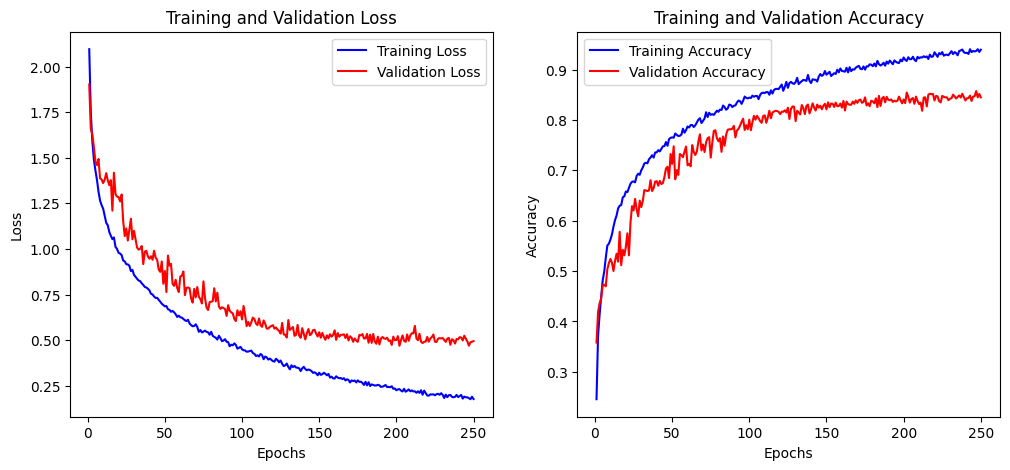

In [46]:
num_epochs = 250

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
start_time = time.time()
for epoch in range(num_epochs):
    model_cnn2.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_cnn2(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_accuracy = correct / total
    train_loss /= len(train_loader)

    model_cnn2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_cnn2(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

## Saving the Models

In [47]:
# Save the DNN model
torch.save(model_dnn.state_dict(), 'model_dnn.pth')

# Save the CNN model 1
torch.save(model_cnn1.state_dict(), 'model_cnn1.pth')

# Save the CNN model 2
torch.save(model_cnn2.state_dict(), 'model_cnn2.pth')

print("Models saved successfully.")

Models saved successfully.
